In [2]:
import gc
import scanit
import torch
import random
import scanpy as sc
import pandas as pd
import anndata
import numpy as np
from scipy import sparse
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.cluster import SpectralClustering, KMeans
import matplotlib.pyplot as plt
import stlearn as st
from pathlib import Path

In [3]:
sp_datadir = "./data"

In [4]:
pts = np.loadtxt(sp_datadir+'/positions.csv')
X_sp = sparse.load_npz(sp_datadir+'/expression.npz')
X_sp = X_sp.toarray()
genes_sp = np.loadtxt(sp_datadir+'/genes.txt', dtype=str)
df_sp = pd.DataFrame(data=X_sp, columns=genes_sp)
adata = anndata.AnnData(X = X_sp, var=pd.DataFrame(index=genes_sp))
adata.obsm['spatial'] = pts
adata.obsm['spatial'][:,1] = -adata.obsm['spatial'][:,1]

In [5]:
adata.shape

(523, 10000)

In [6]:
n_sv_genes = 3000
adata_sp = adata.copy()
sc.pp.normalize_total(adata_sp)
df_somde = pd.read_csv('./data/somde_result.csv')
sv_genes = list( df_somde['g'].values[:n_sv_genes] )
adata_sp = adata_sp[:, sv_genes]
sc.pp.log1p(adata_sp)
sc.pp.scale(adata_sp)

In [7]:
scanit.tl.spatial_graph(adata_sp, method='alpha shape', alpha_n_layer=1, knn_n_neighbors=5)
scanit.tl.spatial_representation(adata_sp, n_h=10, n_epoch=2000, lr=0.001, device='cuda', n_consensus=5, projection='mds', 
    python_seed=0, torch_seed=0, numpy_seed=0)

Epoch: 000, Loss: 1.3963
Epoch: 500, Loss: 0.0045
Epoch: 1000, Loss: 0.0111
Epoch: 1500, Loss: 0.0003
Epoch: 1999, Loss: 0.0021
Epoch: 000, Loss: 1.3913
Epoch: 500, Loss: 0.0056
Epoch: 1000, Loss: 0.0028
Epoch: 1500, Loss: 0.0014
Epoch: 1999, Loss: 0.0016
Epoch: 000, Loss: 1.3930
Epoch: 500, Loss: 0.0223
Epoch: 1000, Loss: 0.0009
Epoch: 1500, Loss: 0.0023
Epoch: 1999, Loss: 0.0005
Epoch: 000, Loss: 1.3887
Epoch: 500, Loss: 0.0018
Epoch: 1000, Loss: 0.0030
Epoch: 1500, Loss: 0.0002
Epoch: 1999, Loss: 0.0009
Epoch: 000, Loss: 1.3901
Epoch: 500, Loss: 0.0385
Epoch: 1000, Loss: 0.0007
Epoch: 1500, Loss: 0.0006
Epoch: 1999, Loss: 0.0003


In [8]:
sc.pp.neighbors(adata_sp, use_rep='X_scanit', n_neighbors=10)
sc.tl.leiden(adata_sp, resolution=0.3)

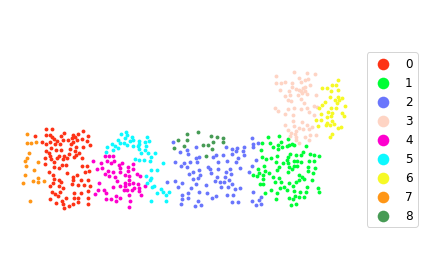

In [18]:
import plotly
pts = adata_sp.obsm['spatial']
color_list = plotly.colors.qualitative.Light24
labels_pred = np.array( adata_sp.obs['leiden'], int )
labels = list(set(labels_pred))
labels = list(np.sort(labels))
for j in range(len(labels)):
    label = labels[j]
    idx = np.where(labels_pred == label)[0]
    plt.scatter(pts[idx,0], -pts[idx,1], c=color_list[j], label = label, s=15, linewidth=0)
plt.axis('equal')
plt.axis('off')
plt.legend(markerscale=3, loc='center left', bbox_to_anchor=(1,0.5), fontsize=12)
plt.tight_layout()
plt.savefig('./figures/scanit_segmentation.pdf', bbox_inches='tight')

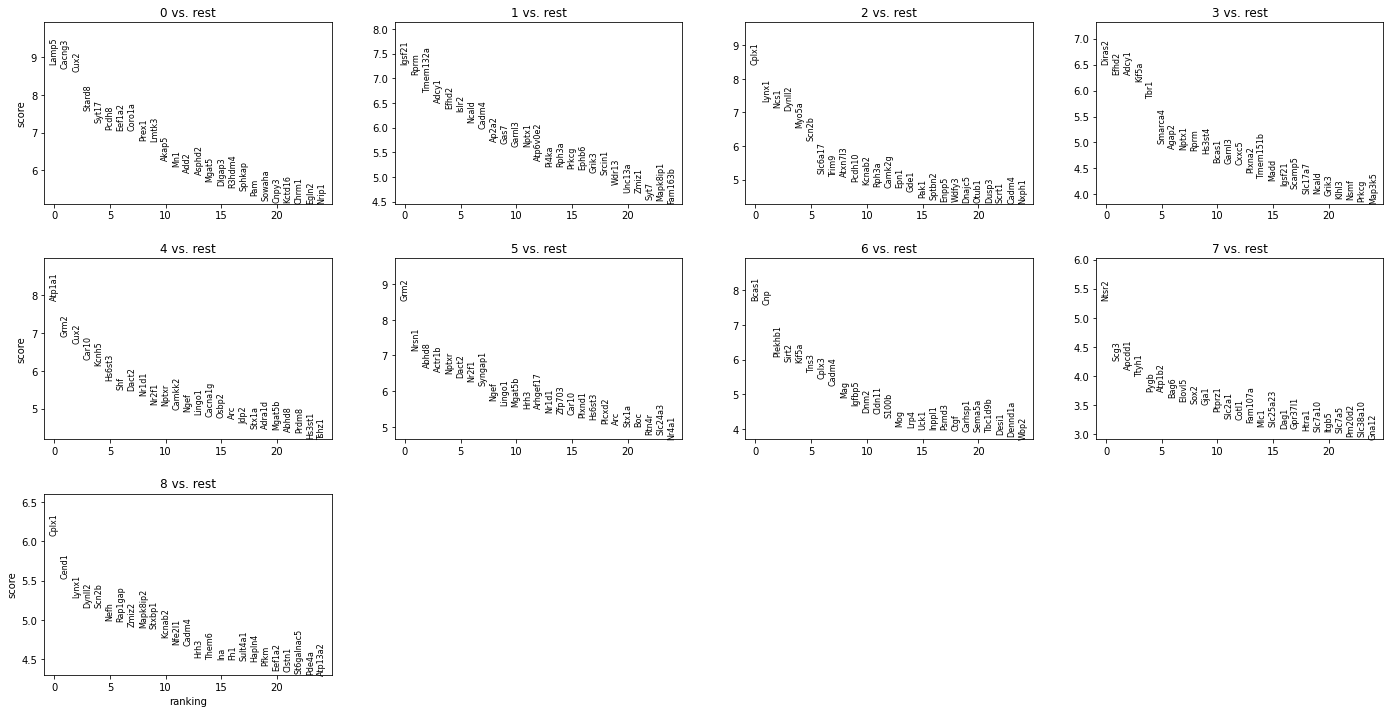

In [10]:
adata_sp_marker = adata.copy()
adata_sp_marker.obs['leiden'] = adata_sp.obs['leiden']
sc.pp.normalize_total(adata_sp_marker)
sc.pp.log1p(adata_sp_marker)
adata_sp_marker.raw = adata_sp_marker
sc.pp.scale(adata_sp_marker)
sc.tl.rank_genes_groups(adata_sp_marker, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata_sp_marker, n_genes=25, sharey=False)

In [19]:
result = adata_sp_marker.uns['rank_genes_groups']
groups = result['names'].dtype.names
marker_genes = []
for group in groups:
    marker_genes.extend(list(result['names'][group][:3]))

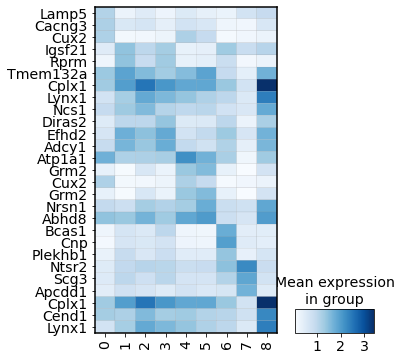

In [26]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 17
gs = sc.pl.matrixplot(adata_sp_marker, marker_genes, groupby='leiden', dendrogram=False,
    use_raw=True, cmap='Blues',  swap_axes=True, figsize=(5,6), save="scanit_segmentation.pdf")

In [13]:
result = adata_sp_marker.uns['rank_genes_groups']
groups = result['names'].dtype.names
marker_genes = []
for group in groups:
    marker_genes.extend(list(result['names'][group][:1]))

In [14]:
adata_sp_plot = adata.copy()
sc.pp.normalize_total(adata_sp_plot)
sc.pp.log1p(adata_sp_plot)
pts = adata_sp_plot.obsm['spatial']
for i in range(len(marker_genes)):
    expr = np.array(adata_sp_plot[:,marker_genes[i]].X).reshape(-1)
    idx = np.argsort(expr)
    plt.scatter(pts[idx,0], -pts[idx,1], c=expr[idx], linewidth=0, s=10, cmap='coolwarm')
    plt.axis('equal'); plt.axis('off')
    plt.colorbar()
    plt.savefig("./figures/feature_plot_domain%d_%s.pdf" %(i, marker_genes[i]))
    plt.clf()

<Figure size 432x288 with 0 Axes>

### **Annotated cell types (by Giotto)**

In [28]:
X = pd.read_csv("./giotto/data/raw_exprs.csv", index_col=0)

In [29]:
adata_sc = anndata.AnnData(X=X)

In [30]:
celltypes = pd.read_csv("./giotto/data/celltype_annotation.csv", index_col=0)
adata_sc.obs['celltype_annotated'] = celltypes['x'].astype('category').values
df_pts = pd.read_csv("./giotto/data/spatial_locs.csv", index_col=0)
pts = df_pts[['sdimx', 'sdimy']].values
pts[:,1] = -pts[:,1]
adata_sc.obsm['spatial'] = pts

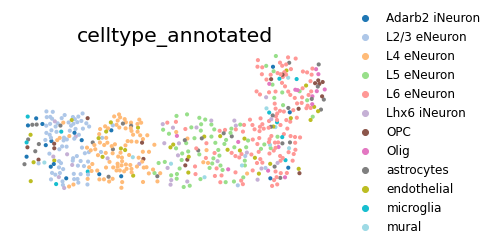

In [36]:
sc.pl.spatial(adata_sc, spot_size=100, color='celltype_annotated', frameon=False, palette='tab20', legend_fontsize=12, save="_giotto_celltype.pdf")

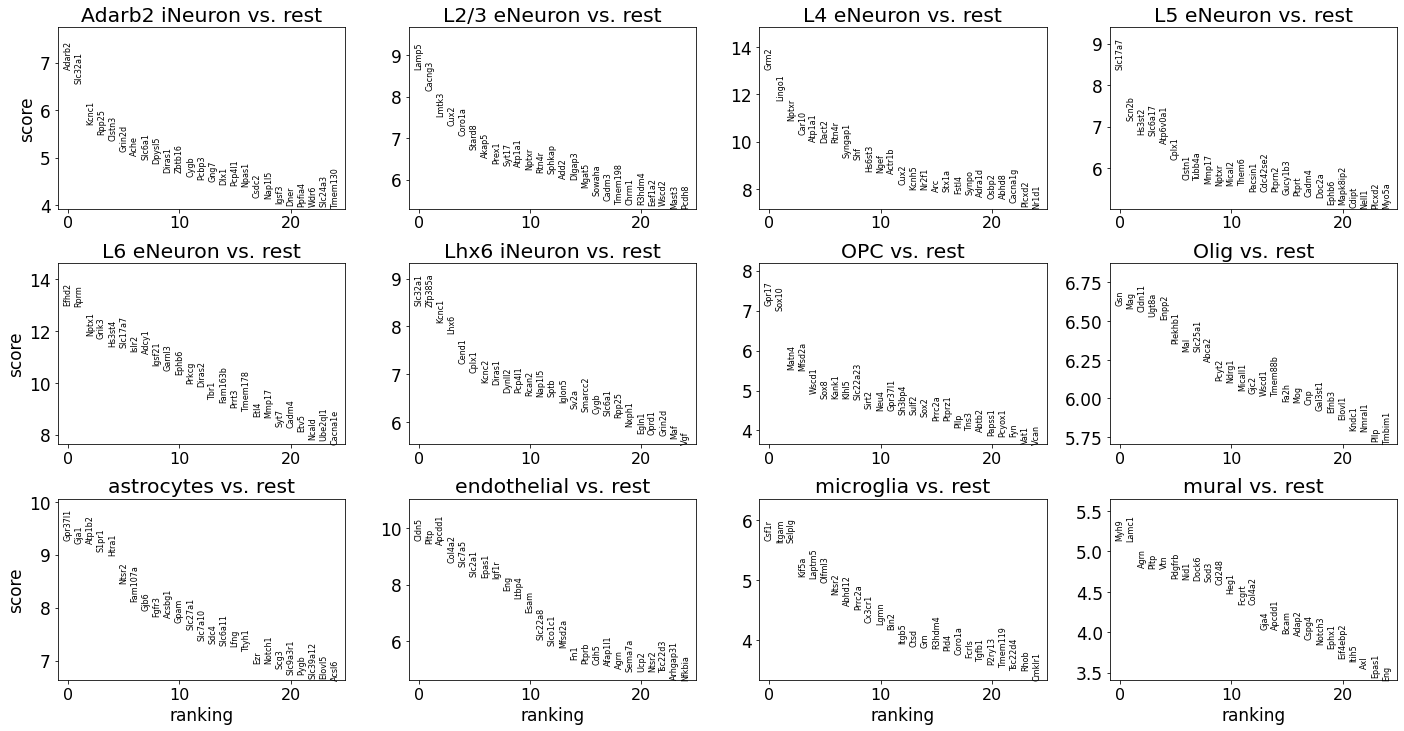

In [37]:
adata_sc_marker = adata_sc.copy()
sc.pp.normalize_total(adata_sc_marker)
sc.pp.log1p(adata_sc_marker)
adata_sc_marker.raw = adata_sc_marker
sc.pp.scale(adata_sc_marker)
sc.tl.rank_genes_groups(adata_sc_marker, 'celltype_annotated', method='wilcoxon')
sc.pl.rank_genes_groups(adata_sc_marker, n_genes=25, sharey=False)

In [38]:
result = adata_sc_marker.uns['rank_genes_groups']
groups = result['names'].dtype.names
marker_genes = []
for group in groups:
    marker_genes.extend(list(result['names'][group][:3]))

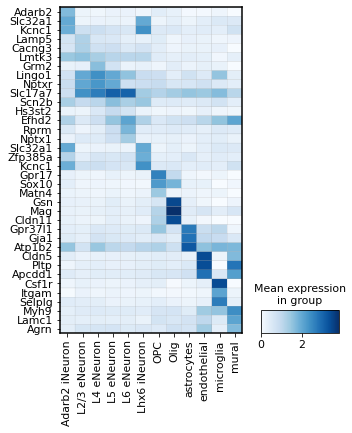

In [43]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 13
gs = sc.pl.matrixplot(adata_sc_marker, marker_genes, groupby='celltype_annotated', dendrogram=False,
    use_raw=True, cmap='Blues',  swap_axes=True, figsize=(5,6), save="celltype_markers.pdf")